Ben-Hazem Mohamed
Charles Louvat

github : https://github.com/carloslvt

## Information sur l'ensemble des données :

La base de données d'évaluation des voitures a été dérivée d'un modèle de décision hiérarchique simple développé à l'origine pour la démonstration de DEX, M. Bohanec, V. Rajkovic : Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). Le modèle évalue les voitures selon la structure conceptuelle suivante :

CAR acceptabilité de la voiture
- PRICE prix global
    - prix d'achat prix d'achat
    - maint prix de la maintenance
- TECH caractéristiques techniques
    - COMFORT confort
    - portes nombre de portes
    - personnes capacité en termes de personnes à transporter
        - lug_boot la taille du coffre à bagages
    - safety sécurité estimée de la voiture

Les attributs d'entrée sont imprimés en minuscules. Outre le concept cible (CAR), le modèle comprend trois concepts intermédiaires : PRIX, TECHNOLOGIE, CONFORT. Dans le modèle original, chaque concept est relié à ses descendants de niveau inférieur par un ensemble d'exemples.

## Exploratory Data Analysis (EDA)

### Analyse de la forme des données

Nous allons dans un premier temps télécharger le dataset grâce à la commande "read_csv" de pandas en spécifiant le séparateur ainsi que le nom des variables

In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [374]:
data = pd.read_csv('car.data', sep = ",", names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "acceptability"])
data.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Regardons maintenant la taille du dataset :

In [375]:
df = data.copy()
df.shape

(1728, 7)

Nous avons 7 variables avec 1728 valeurs pour chaque variable

<AxesSubplot:ylabel='None'>

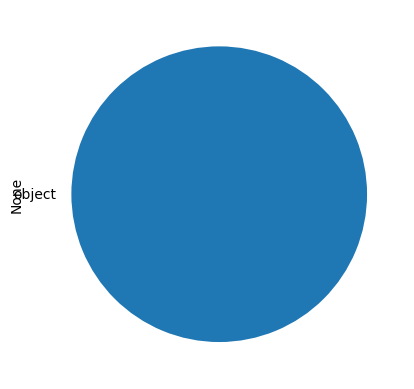

In [376]:
df.dtypes.value_counts().plot.pie()

Nous avons que des variables de type "objet".

Maintenant que nous avons vu les 5 premières colonnes ainsi que la taille, nous allons pouvoir visualiser les différentes variables, en commençant par regarder s'il n'y a pas de valeurs manquantes

<AxesSubplot:>

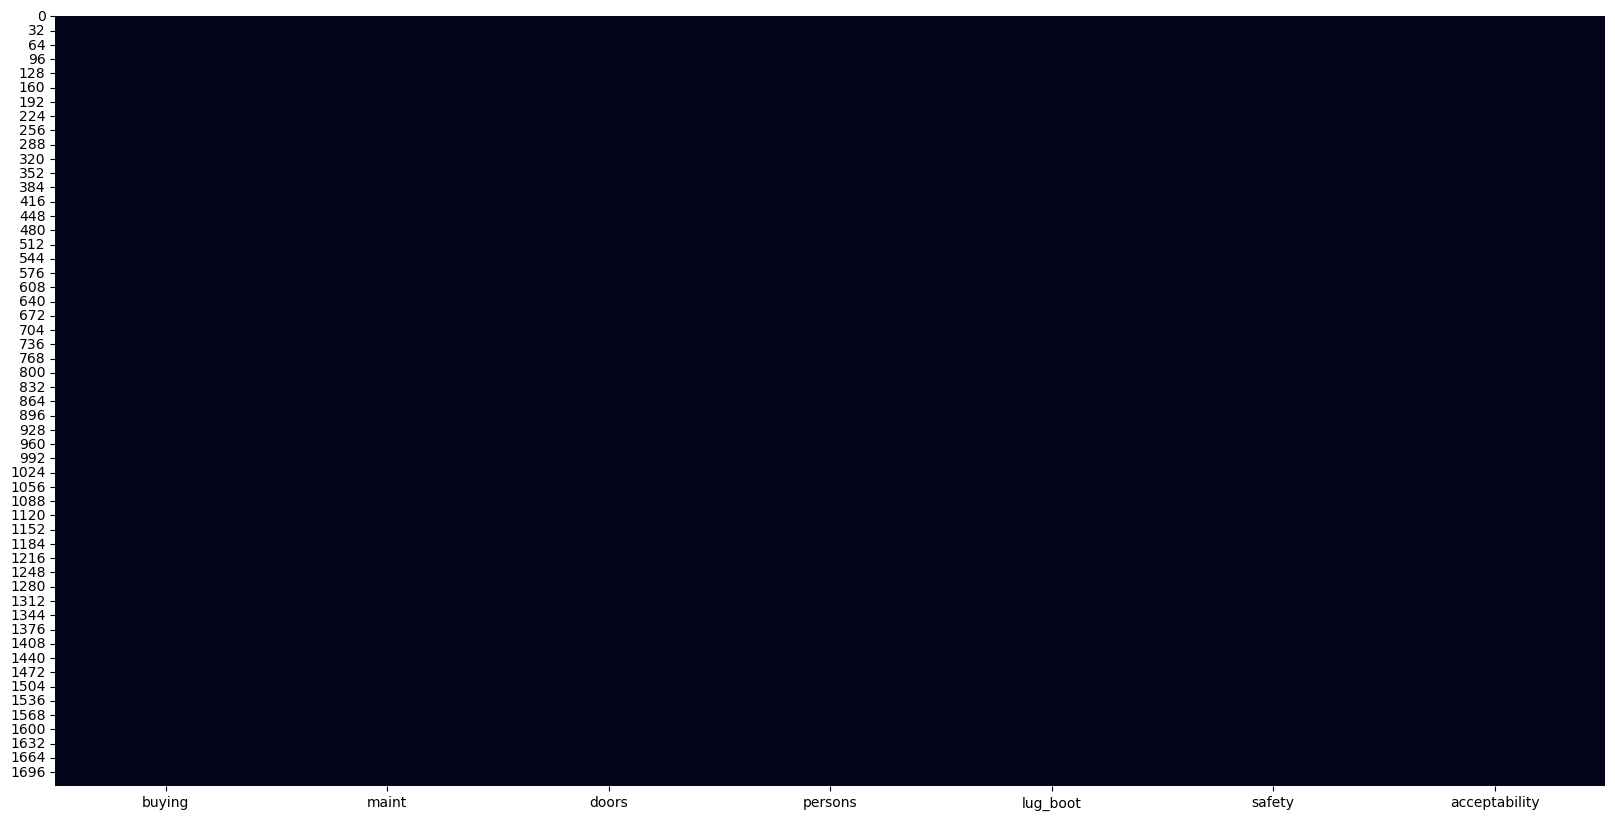

In [377]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [378]:
df.isnull().sum()

buying           0
maint            0
doors            0
persons          0
lug_boot         0
safety           0
acceptability    0
dtype: int64

Très bien, nous n'avons aucune valeur manquante!

### Analyse du fond
#### Examen de la colonne target

In [379]:
df['acceptability'].value_counts(normalize=True)

unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: acceptability, dtype: float64

Nous pouvons voir que la plupart des voitures sont "inacceptables" avec 70%.

#### Exemen des variables qualitatives


In [380]:
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

buying-------------------------------------------- ['vhigh' 'high' 'med' 'low']
maint--------------------------------------------- ['vhigh' 'high' 'med' 'low']
doors--------------------------------------------- ['2' '3' '4' '5more']
persons------------------------------------------- ['2' '4' 'more']
lug_boot------------------------------------------ ['small' 'med' 'big']
safety-------------------------------------------- ['low' 'med' 'high']
acceptability------------------------------------- ['unacc' 'acc' 'vgood' 'good']


Nous avons donc :
- buying --> prix de la voiture (léger, moyen, élevé, très élevé)
- maint --> prix de la maintenance (léger, moyen, élevé, très élevé)
- doors --> nombre de porte (2, 3, 4, 5 et plus)
- persons --> nombre de place (2, 4, plus)
- lug_boot --> taille du coffre (petit, moyen, gros)
- safety --> sécurité estimée de la voiture (léger, moyen, élevé)
- acceptability --> acceptabilité de la voiture (inacceptable, acceptable, bien, très bien)

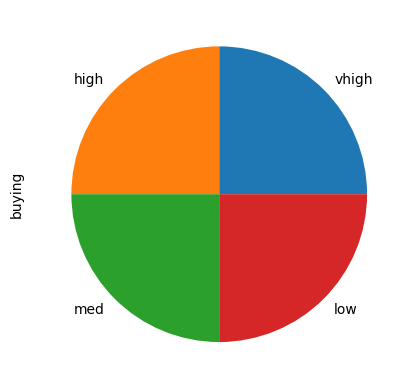

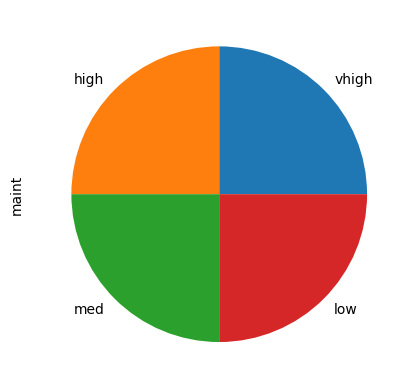

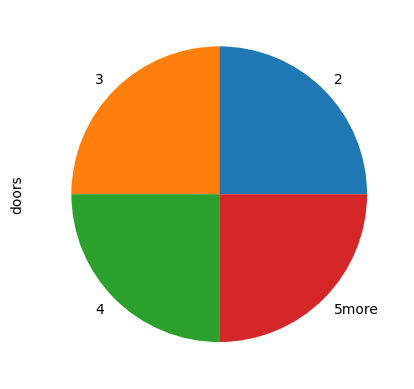

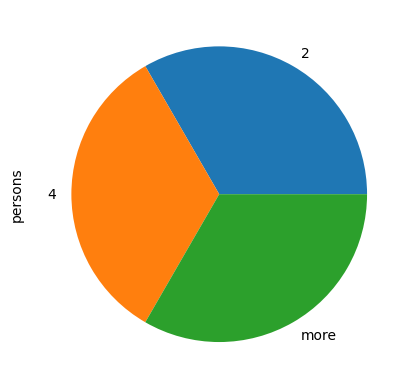

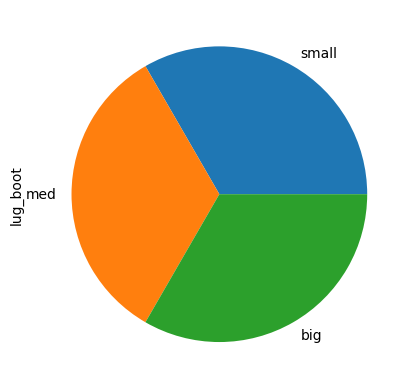

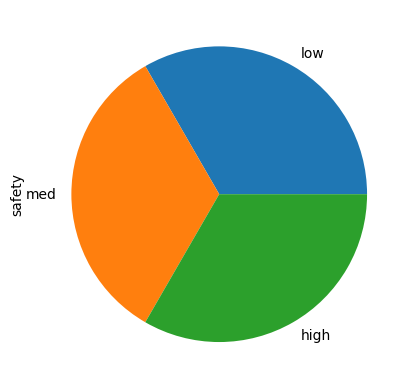

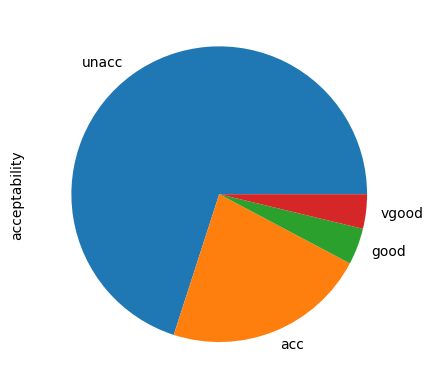

In [381]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

Pour chaque attribut, les données sont équitables.

### Pre-processing

#### TrainTest - Nettoyage - Encodage

Pour commencer, nous splittons notre dataset en 2 afin d'avoir une dataset d'entrainement et un dataset de test. Nous décidons d'utiliser 70% du dataset pour l'entrainement et 30% pour le test. Nous choisissons ces paramètres car si nous utilisons trop de données pour l'entrainement nous allons avoir du sur-apprentissage, et inversement si nous n'avons pas assez de données pour l'entrainement nous allons avec du sous-apprentissage.

In [382]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.3, random_state=0)
trainset['acceptability'].value_counts()

unacc    847
acc      269
vgood     49
good      44
Name: acceptability, dtype: int64

In [383]:
testset['acceptability'].value_counts()

unacc    363
acc      115
good      25
vgood     16
Name: acceptability, dtype: int64

Ensuite, nous devons encoder nos données afin d'avoir seulement des integer. En effet, le classifieur n'accepte pas les données de type "object".

Pour ce faire, nous avons créé une fonction à cet effet.

In [384]:
def _encodage(df):
    """
    Permet de encoder les variables de type "object" en "int"
    
    :param: df: dataframe en entrée
    return: dataframe encoder
    """
    code = {'low':0,
            'med':1,
            'high':2,
            'vhigh':3,
            'small':0,
            'med':1,
            'big':2,
            'unacc':0,
            'acc':1,
            'good':2,
            'vgood':3,
            '2':0,
            '3':1,
            '4':2,
            '5more':3,
            'more':3
           }
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [385]:
def _preprocessing(df):
    """
    split le dataframe en données d'apprentissage (X) et target 'y'
    
    :param: df: dataframe en entrée
    return: X et y
    """
    df = _encodage(df)
    
    X = df.drop('acceptability', axis=1)
    y = df['acceptability']
    
    print(y.value_counts())
    return X, y


Avec les fonctions créées, nous pouvons maintenant séparer la target des autres données avec l'encodage.

In [386]:
X_train, y_train = _preprocessing(trainset)

0    847
1    269
3     49
2     44
Name: acceptability, dtype: int64


In [387]:
X_test, y_test = _preprocessing(testset)

0    363
1    115
2     25
3     16
Name: acceptability, dtype: int64


#### Procédure d'évaluation

Maintenant que nous avons nos différents dataset prêt, nous pouvons passer à l'évaluation du modèle. Ici encore, nous écrivons une fonction qui va permettre d'entrainement le modèle, de prédire les données test et ainsi calculer la matrice de confusion ainsi qu'un petit rapport de plusieurs métrics (precision, recall, f1-score et accuracy)

In [388]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [389]:
def _evaluation(model):
    """
    fonction d'évaluation d'un modèle
    
    :param: model: model de machine learning en entrée
    return: matrice de confusion, rapport d'évaluation
    """
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, ypred)
    sns.heatmap(cf_matrix, annot=True)
    
    print(classification_report(y_test, ypred))
    
    

    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(model, filled=True)


### Modélisation

Pour l'évaluation, nous avons décidé de choisir l'arbre de décision:

Un algorithme d'arbre de décision est l'un des algorithmes d'apprentissage automatique les plus populaires. Il utilise une structure arborescente et leurs combinaisons possibles pour résoudre un problème particulier. Il appartient à la classe des algorithmes d'apprentissage supervisé où il peut être utilisé à la fois à des fins de classification et de régression. Un arbre de décision est une structure qui comprend un nœud racine, des branches et des nœuds feuilles. Chaque nœud interne désigne un test sur un attribut, chaque branche désigne le résultat d'un test et chaque nœud feuille contient une étiquette de classe. Le nœud le plus haut de l'arborescence est le nœud racine.

In [390]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

Avant de commencer l'entrainement, nous pouvons définir la valeur de différents hyperparamètres tels :

- criterion (La fonction pour mesurer la qualité d'un split)
- max_depth (profondeur maximale de l'arbre)
- min_samples_split (le nombre minimum d'échantillons requis pour diviser un nœud interne)
- min_samples_leaf (le nombre minimum d'échantillons requis pour être à un noeud feuille)

Ne sachant pas exactement quels sont les hyperparamètres optimaux, nous effectuons un gridSearch afin de les trouver. 

In [391]:
param_dict = {"criterion":['gini','entropy'],
              "max_depth":range(1,10),
              "min_samples_split":range(1,10),
              "min_samples_leaf" :range(1,5)}

Nous pouvons maintenant entrainer notre model tout en calculant les meilleurs paramètres grâce au GridSearchCV.

In [392]:
clf = DecisionTreeClassifier()
grid = GridSearchCV(clf,
                   param_grid = param_dict,
                   cv = 10,
                   verbose = 1,
                   n_jobs = -1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [393]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Voici les meilleurs paramètres à utiliser pour ce dataset, calculons maintenant le score.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       363
           1       0.97      0.89      0.93       115
           2       0.71      0.88      0.79        25
           3       0.89      1.00      0.94        16

    accuracy                           0.97       519
   macro avg       0.89      0.94      0.91       519
weighted avg       0.97      0.97      0.97       519



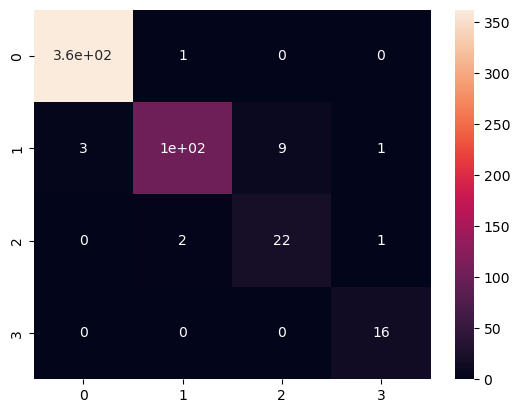

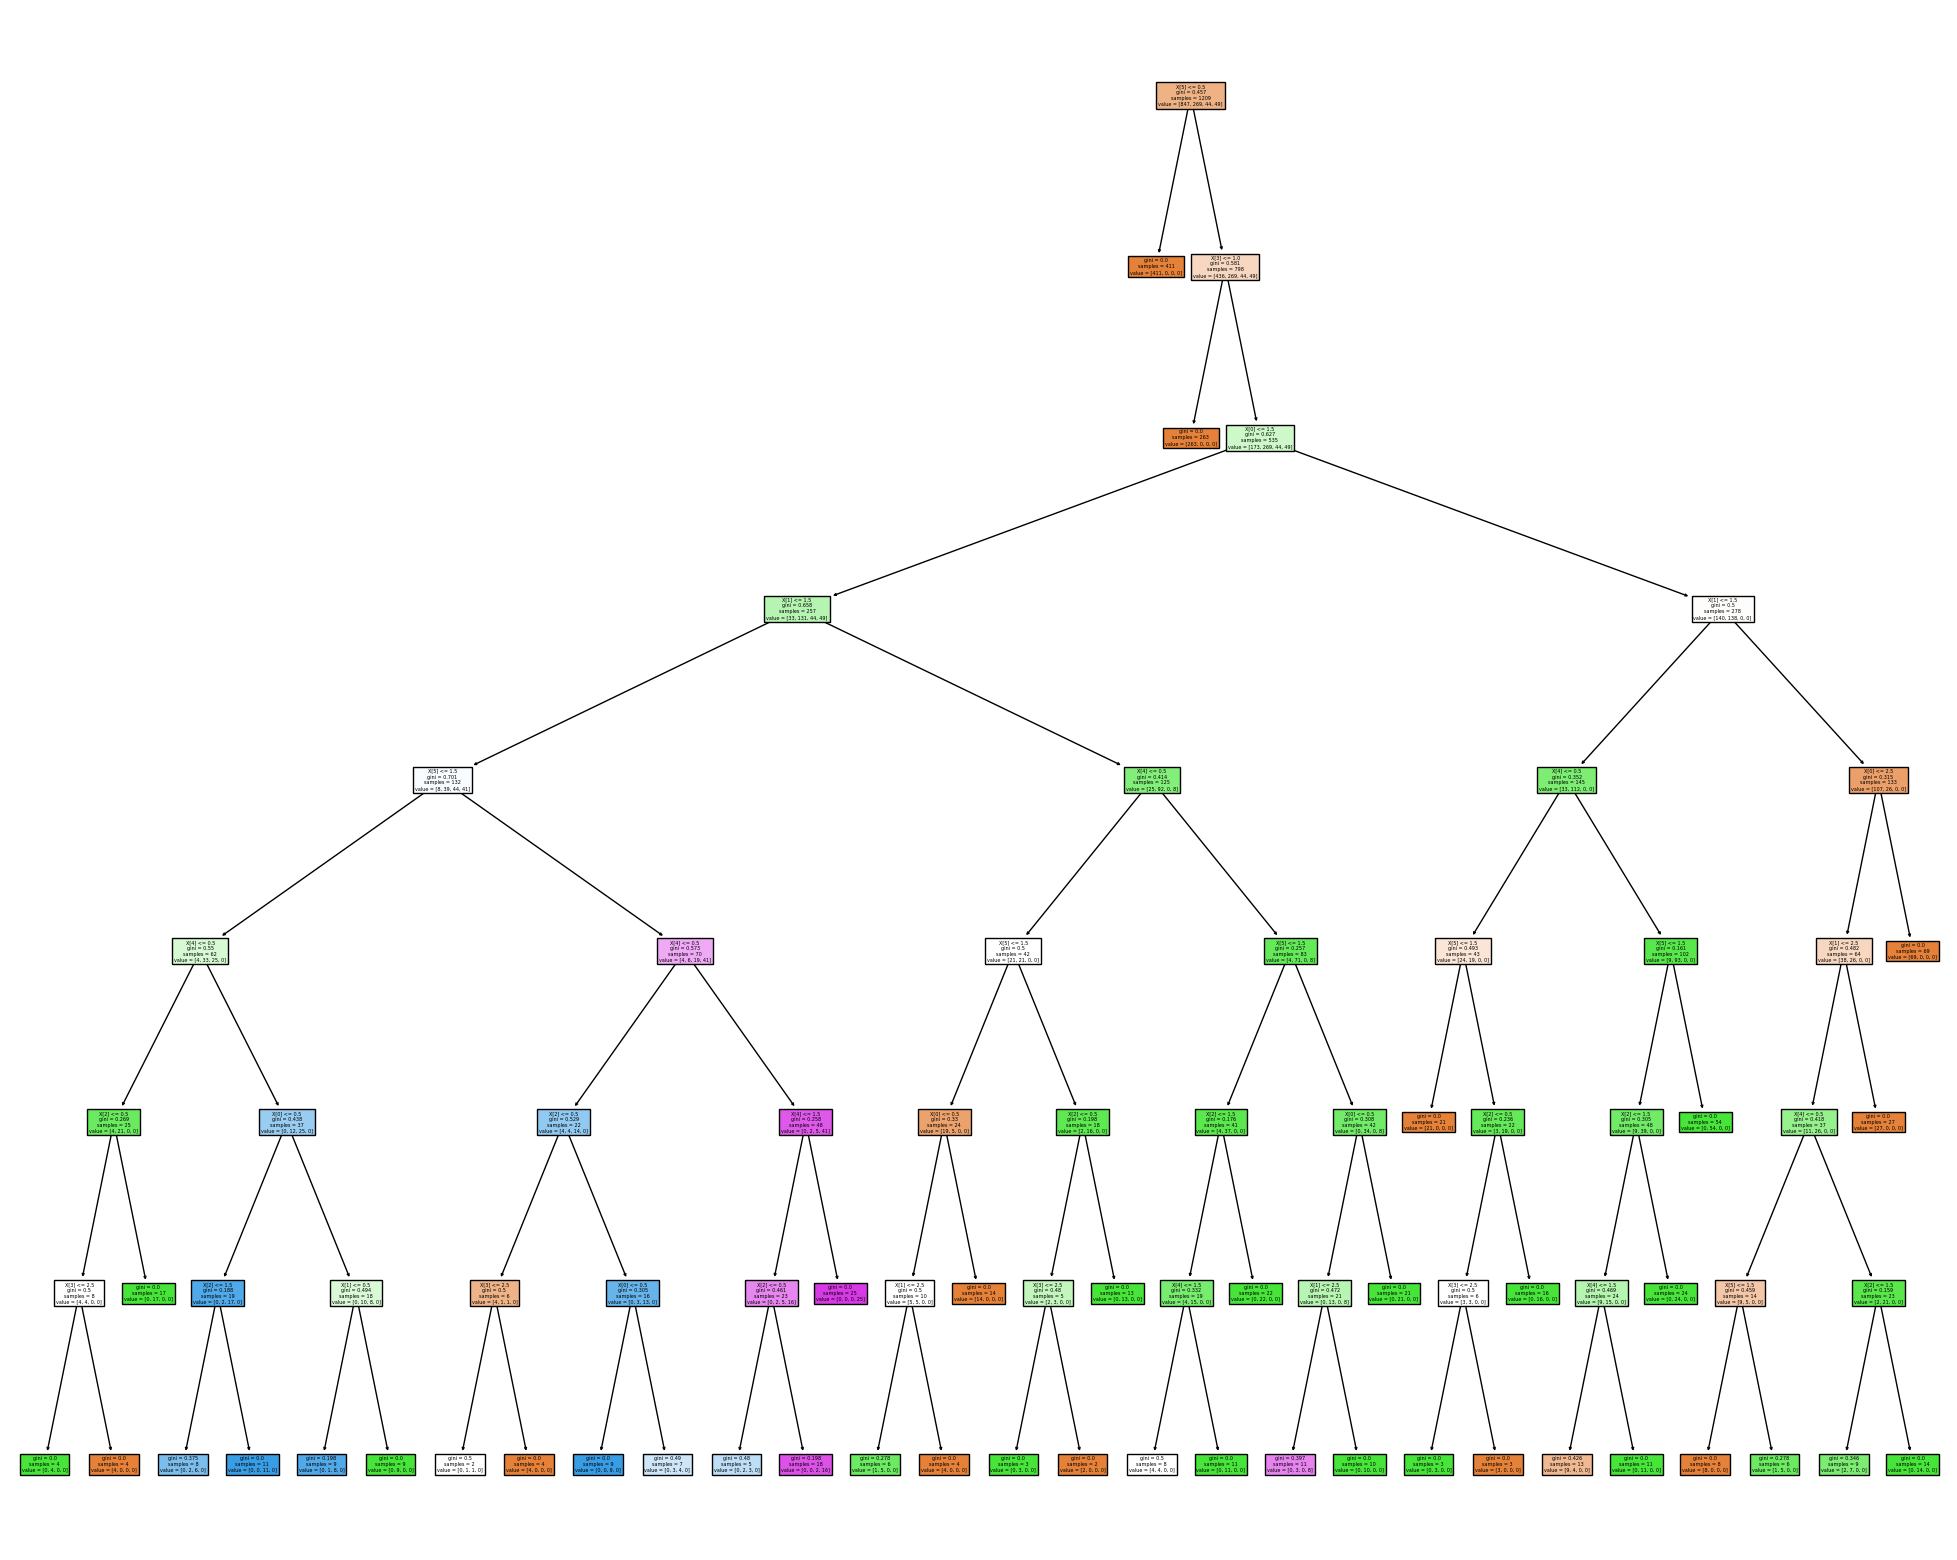

In [394]:
_evaluation(grid.best_estimator_)

Nous obtenons un très bon score de 97%

### Affichage de la surface de décision

Pour une paire d’attributs, c’est-à-dire pour des observations en deux dimensions,
nous pouvons visualiser la surface de décision en 2 dimensions. D’abord on
discrétise le domaine bidimensionnel avec un pas constant et ensuite on évalue le
modèle sur chaque point de la grille.

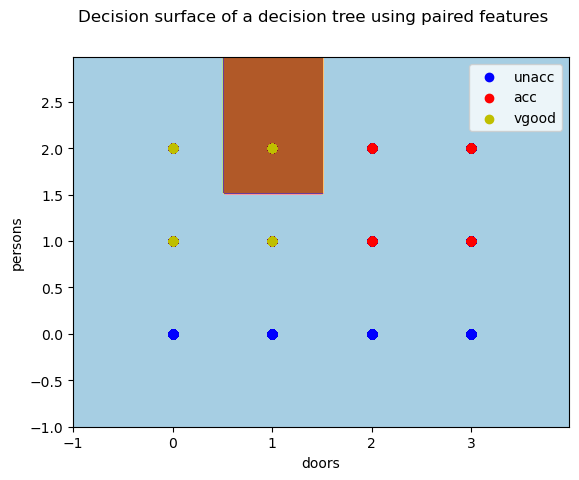

In [412]:
# Paramètres
n_classes = 4
plot_colors = "bry" # blue-red-yellow
plot_step = 0.02

# Choisir les attributs longueur et largeur des pétales

pair = [1, 5]

# On ne garde seulement les deux attributs
target_name = df['acceptability']

df1 = df.copy()
df1 = _encodage(df1)
X = df1.iloc[:,pair]
y = df1['acceptability']

X = X.to_numpy()
y = y.to_numpy()

# Apprentissage de l'arbre
clf = DecisionTreeClassifier().fit(X, y)

# Affichage de la surface de décision
x_min, x_max = int(X[:, 0].min()) - 1, int(X[:, 0].max()) + 1
y_min, y_max = int(X[:, 1].min()) - 1, int(X[:, 1].max()) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.xlabel(X1.columns[0])
plt.ylabel(X1.columns[1])
plt.axis("tight")

# Affichage des points d'apprentissage
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_name.unique()[i], cmap=plt.cm.Paired)
    
plt.axis("tight")
plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()

Après avoir essayé d'afficher la surface de décision sur différentes paires, nous nous apercevons qu'il n'y a pas de résultat. En effet, ici nous avons encodé nos données de la même manière (0, 1, 2, ..), du coup on se retrouve avec des données qui se chevauchent sur le graphique.